# SNe Ia and Hubble Diagram

## Residual dependence on host galaxy properties

### Load SN data.

In [1]:
import pickle
import numpy as np
max_dist_arcsec = 1.0
with open("./post_data/valid_host_galaxies.pkl","rb") as f:
    data = pickle.load(f)

SN_sample = data["SN_sample"]
valid_SN_ids = data["valid_SN_ids"]
valid_host_galaxies = data["valid_host_galaxies"]

In [2]:
import matplotlib.pyplot as plt

# Set global plotting font parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 20,

    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,

    "figure.titlesize": 20,
})

std_rc = plt.rcParams.copy()

### Cosmology Fitting

#### Cosmology models

In [3]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad

models = ["Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"]

def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) = H(z)/H0"""
    
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))

def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Luminosity distance under Flat ΛCDM model

    Args:
        z: redshift
        Omega_m: matter density parameter
        H0: Hubble constant (km/s/Mpc)

    Returns:
        luminosity distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0  # Hubble distance in Mpc

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    # Luminosity distance: dL = (1+z) * dC * dH
    return (1 + z) * dC * dH
def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Compute distance modulus for given cosmological model

    Args:
        z: redshift
        model: model name
            'Flat_LCDM': flat ΛCDM
            'Open_LCDM': open ΛCDM
            'Flat_wCDM': flat wCDM
            'Flat_w0waCDM': flat w0waCDM
        **kwargs: model parameters

    Returns:
        luminosity distance (Mpc)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        #"Open_LCDM": luminosity_distance_Open_LCDM,
        #"Flat_wCDM": luminosity_distance_Flat_wCDM,
        #"Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Unsupported model: {model}. Available: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

##### Flat LCDM

In [4]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,

    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,

    "figure.titlesize": 12,
})

Omega_m = 0.3289 +0.0152 -0.0143
M       = 5.0081 +0.0099 -0.0103


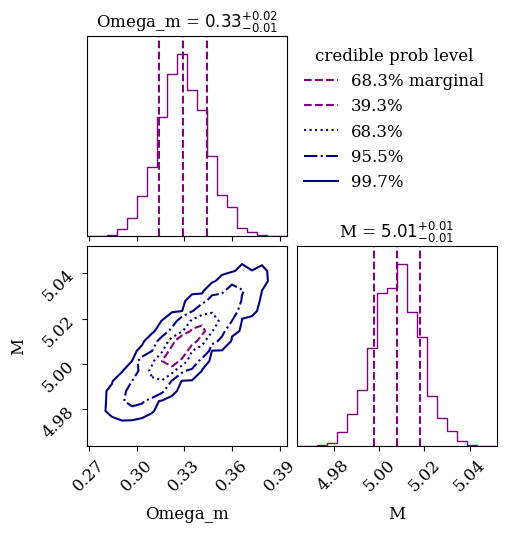

In [6]:
import pickle
from ultranest.plot import cornerplot
from ultranest.utils import resample_equal

with open(f'fits/Flat_LCDM_wide_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)

cornerplot(Flat_LCDM_result)

# Extract weighted posterior
samples   = Flat_LCDM_result["weighted_samples"]["points"]
weights   = Flat_LCDM_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16,       M_q50,       M_q84       = np.percentile(equal_samples[:, 1], [16, 50, 84])

print(f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
      f"-{Omega_m_q50 - Omega_m_q16:.4f}")
print(f"M       = {M_q50:.4f} +{M_q84 - M_q50:.4f} "
      f"-{M_q50 - M_q16:.4f}")

In [7]:
plt.rcParams.update(std_rc)

### Residuals and W1 band

#### Compute Hubble residuals for all SNe

In [8]:
def flux_to_w1mag(flux_w1):
    """
    Convert WISE W1 flux (nanomaggies) to AB magnitude.
    Legacy Survey convention:
        m = 22.5 - 2.5 * log10(flux)
    """
    if flux_w1 <= 0 or np.isnan(flux_w1):
        return np.nan
    return 22.5 - 2.5 * np.log10(flux_w1)

z_all = SN_sample['zHD'].data
mu_obs_all = SN_sample['MU'].data

# Model distance modulus for Flat ΛCDM
mu_model_all = np.array([
    distance_modulus(z, [Omega_m_q50], model='Flat_LCDM') + M_q50
    for z in z_all
])

# Hubble residuals: Δμ = μ_obs − μ_model
residual_all = mu_obs_all - mu_model_all

#### Select SNe with valid host galaxies and W1 flux

In [9]:
SN_ids = []
W1_mag = []
residuals = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]

    # Require W1 flux measurement
    if 'flux_w1' not in host.colnames:
        continue

    flux_w1 = host['flux_w1'][0]
    w1_mag = flux_to_w1mag(flux_w1)

    # Remove invalid values
    if np.isnan(w1_mag):
        continue

    SN_ids.append(SN_id)
    W1_mag.append(w1_mag)
    residuals.append(residual_all[SN_id])

SN_ids = np.array(SN_ids)
W1_mag = np.array(W1_mag)
residuals = np.array(residuals)

print(f"Final sample size used in residual–W1 analysis: {len(W1_mag)}")

Final sample size used in residual–W1 analysis: 1091


#### Hubble residuals vs W1 magnitude: linear trend test

Linear trend: Δμ = (0.0137) × W1 + (-0.2259)


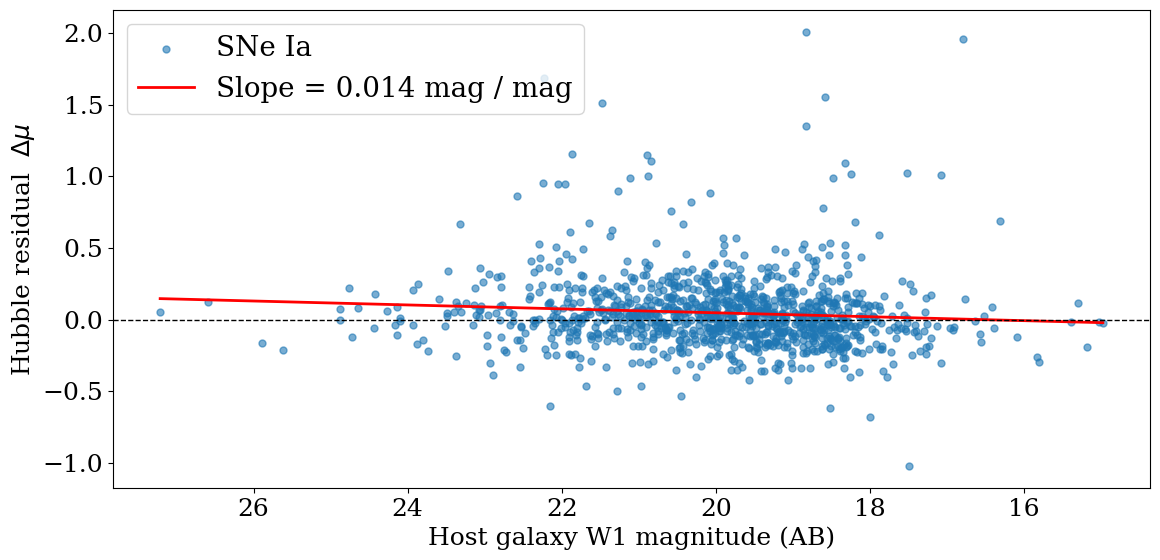

In [10]:
coef = np.polyfit(W1_mag, residuals, 1)
slope, intercept = coef

xfit = np.linspace(W1_mag.min(), W1_mag.max(), 200)
yfit = slope * xfit + intercept

print(f"Linear trend: Δμ = ({slope:.4f}) × W1 + ({intercept:.4f})")

plt.figure(figsize=(12, 6))
plt.scatter(W1_mag, residuals, s=25, alpha=0.6, label='SNe Ia')
plt.plot(
    xfit, yfit,
    color='r', lw=2,
    label=f'Slope = {slope:.3f} mag / mag'
)

plt.axhline(0.0, color='k', ls='--', lw=1)
plt.xlabel('Host galaxy W1 magnitude (AB)')
plt.ylabel(r'Hubble residual  $\Delta\mu$')
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
mu_err = SN_sample['MUERR'].data[SN_ids]

from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

sigma_eff = np.sqrt(mu_err**2 + 0.1**2)  # intrinsic scatter included

popt, pcov = curve_fit(
    linear_model,
    W1_mag,
    residuals,
    sigma=sigma_eff,
    absolute_sigma=True
)

slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])

print(f"Slope = {slope:.4f} ± {slope_err:.4f}")
print(f"Significance = {abs(slope)/slope_err:.2f} sigma")

Slope = 0.0121 ± 0.0036
Significance = 3.34 sigma


In [12]:
import numpy as np
from scipy import stats

# 计算皮尔逊相关系数和p值
pearson_r, pearson_p = stats.pearsonr(W1_mag, residuals)

print("\n=== Pearson Correlation Test ===")
print(f"Pearson correlation coefficient (r) = {pearson_r:.4f}")
print(f"p-value = {pearson_p:.4e}")

# 解释相关系数的强度
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r >= 0.8:
        return "very strong"
    elif abs_r >= 0.6:
        return "strong"
    elif abs_r >= 0.4:
        return "moderate"
    elif abs_r >= 0.2:
        return "weak"
    else:
        return "very weak or none"

strength = interpret_correlation(pearson_r)
print(f"Correlation strength: {strength}")

# 检查统计显著性
alpha = 0.05  # 显著性水平
if pearson_p < alpha:
    print(f"Correlation is statistically significant at α={alpha} level")
else:
    print(f"Correlation is NOT statistically significant at α={alpha} level")


=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = 0.0849
p-value = 5.0135e-03
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level


## With Redshift

Pearson r (residual vs z) = -0.035
p-value = 2.43e-01


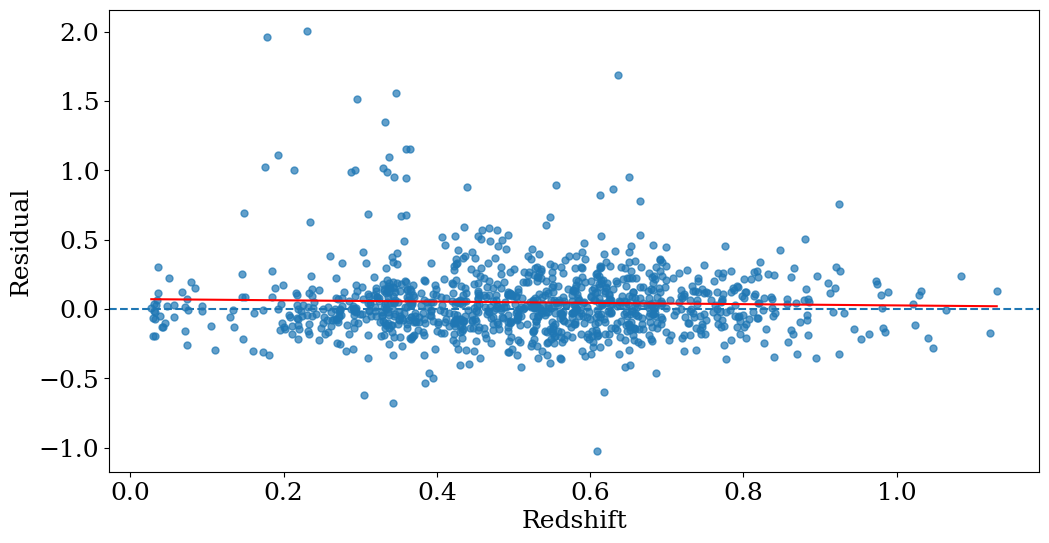

In [14]:
from scipy.stats import pearsonr

z = z_all[SN_ids]
r_res_z, p_res_z = pearsonr(z, residuals)

print(f"Pearson r (residual vs z) = {r_res_z:.3f}")
print(f"p-value = {p_res_z:.2e}")

plt.figure(figsize=(12, 6))
plt.scatter(z_all[SN_ids], residuals, s=25, alpha=0.7)
plt.axhline(0, ls='--')
p = np.polyfit(z, residuals, 1)
plt.plot(z, np.polyval(p, z), color='r')
plt.xlabel('Redshift')
plt.ylabel('Residual')
plt.show()

CMT: We find no correlation between Hubble residuals and redshift.

Pearson r (W1 vs z) = 0.164
p-value = 4.94e-08


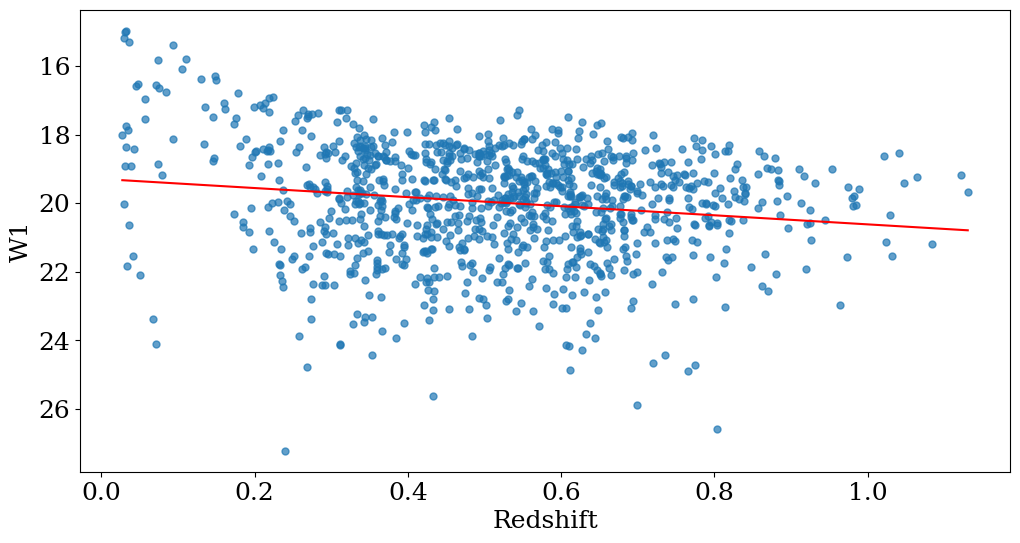

In [15]:
r_w1_z, p_w1_z = pearsonr(z, W1_mag)

print(f"Pearson r (W1 vs z) = {r_w1_z:.3f}")
print(f"p-value = {p_w1_z:.2e}")

plt.figure(figsize=(12, 6))
plt.scatter(z_all[SN_ids], W1_mag, s=25, alpha=0.7)
p = np.polyfit(z, W1_mag, 1)
plt.plot(z, np.polyval(p, z), color='r')
plt.xlabel('Redshift')
plt.ylabel('W1')
plt.gca().invert_yaxis()
plt.show()

CMT: Host galaxy W1 magnitude shows a strong dependence on redshift, consistent with selection effects. *(Is this correct?)*

Pearson r (W1 vs log DL) = 0.221
p-value = 1.70e-13


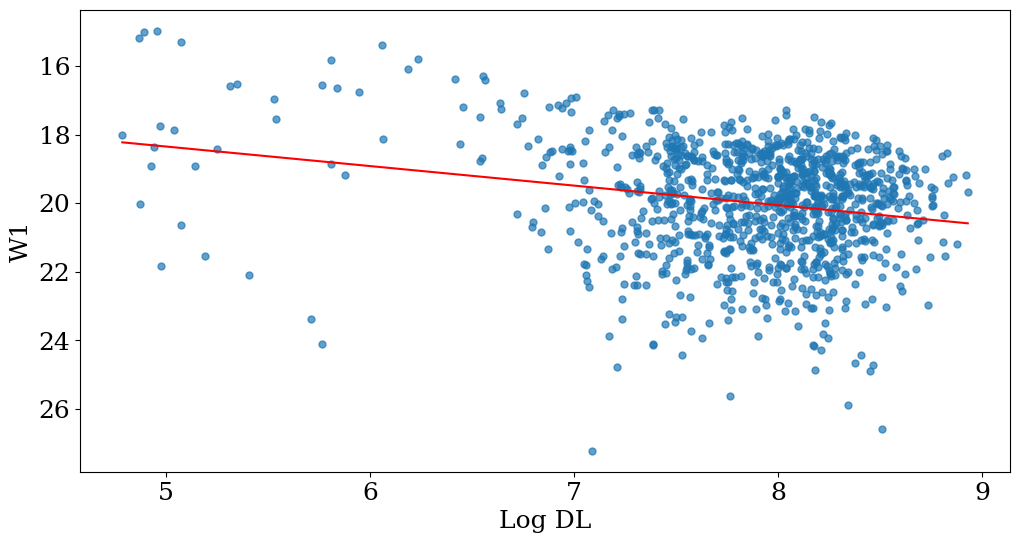

In [16]:
log_luminosity_distance_W1_samples = np.log(luminosity_distance_Flat_LCDM(z_all[SN_ids], [Omega_m_q50], H0=70.0))

r_w1_log_DL, p_w1_log_DL = pearsonr(log_luminosity_distance_W1_samples, W1_mag)

print(f"Pearson r (W1 vs log DL) = {r_w1_log_DL:.3f}")
print(f"p-value = {p_w1_log_DL:.2e}")

plt.figure(figsize=(12, 6))
plt.scatter(log_luminosity_distance_W1_samples, W1_mag, s=25, alpha=0.7)
p_DL = np.polyfit(log_luminosity_distance_W1_samples, W1_mag, 1)
plt.plot(log_luminosity_distance_W1_samples, np.polyval(p_DL, log_luminosity_distance_W1_samples), color='r')
plt.xlabel('Log DL')
plt.ylabel('W1')
plt.gca().invert_yaxis()
plt.show()

CMT: See selection effect.

In [17]:
z = z_all[SN_ids]

z_bins = [0.01, 0.1, 0.2, 0.4, 0.8, 1.0]
z_idx = np.digitize(z, z_bins)

for i in range(1, len(z_bins)):
    mask = z_idx == i
    if np.sum(mask) < 30:
        continue

    slope_i, intercept_i = np.polyfit(
        W1_mag[mask],
        residuals[mask],
        1
    )

    print(f"z bin {z_bins[i-1]}–{z_bins[i]}: slope = {slope_i:.4f}")

z bin 0.01–0.1: slope = 0.0186
z bin 0.2–0.4: slope = 0.0124
z bin 0.4–0.8: slope = 0.0151
z bin 0.8–1.0: slope = 0.0417


In [18]:
from sklearn.linear_model import LinearRegression

X = np.vstack([W1_mag, z]).T
y = residuals
reg = LinearRegression().fit(X, y)

print(f"Δμ = {reg.coef_[0]:.4f} W1 + {reg.coef_[1]:.4f} z + {reg.intercept_:.4f}")

Δμ = 0.0150 W1 + -0.0659 z + -0.2188


#### Hubble residuals vs W1-W2 color: linear trend test

In [19]:
SN_ids = []
W1W2_color = []
residuals = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]

    # Require both W1 and W2 flux measurements
    if 'flux_w1' not in host.colnames or 'flux_w2' not in host.colnames:
        continue

    flux_w1 = host['flux_w1'][0]
    flux_w2 = host['flux_w2'][0]

    w1_mag = flux_to_w1mag(flux_w1)
    w2_mag = flux_to_w1mag(flux_w2)

    # Remove invalid values
    if np.isnan(w1_mag) or np.isnan(w2_mag):
        continue

    SN_ids.append(SN_id)
    W1W2_color.append(w1_mag - w2_mag)  # W1-W2 color
    residuals.append(residual_all[SN_id])

SN_ids = np.array(SN_ids)
W1W2_color = np.array(W1W2_color)
residuals = np.array(residuals)

print(f"Final sample size used in residual–W1-W2 analysis: {len(W1W2_color)}")

Final sample size used in residual–W1-W2 analysis: 959


Slope (Δμ vs W1-W2) = -0.0049 ± 0.0088
Significance = 0.55 sigma


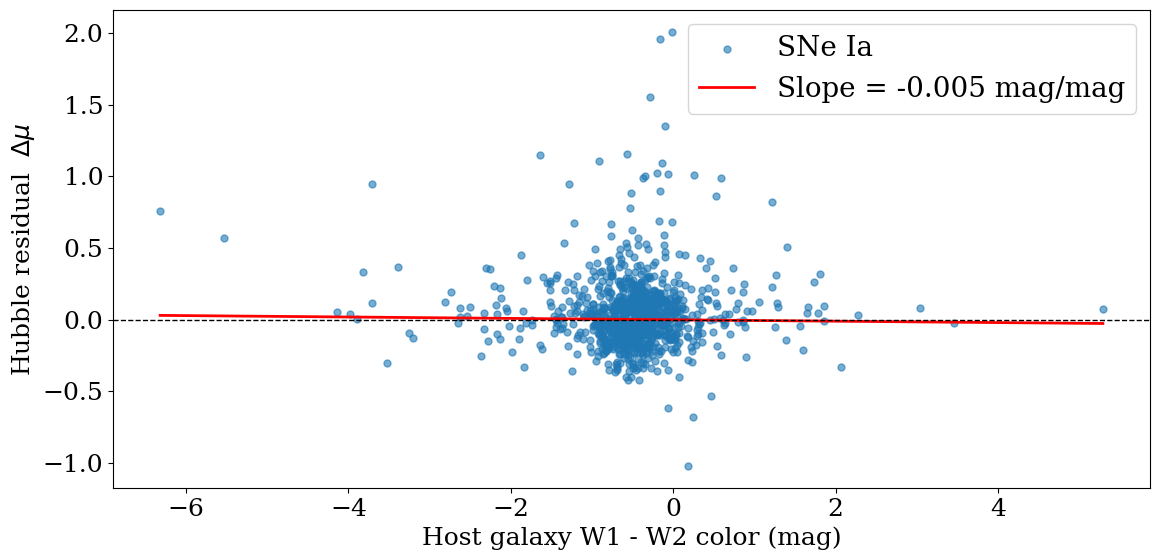

In [20]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

mu_err = SN_sample['MUERR'].data[SN_ids]
sigma_eff = np.sqrt(mu_err**2 + 0.1**2)  # intrinsic scatter

popt, pcov = curve_fit(
    linear_model,
    W1W2_color,
    residuals,
    sigma=sigma_eff,
    absolute_sigma=True
)

slope, intercept = popt
slope_err = np.sqrt(pcov[0, 0])

print(f"Slope (Δμ vs W1-W2) = {slope:.4f} ± {slope_err:.4f}")
print(f"Significance = {abs(slope)/slope_err:.2f} sigma")

import matplotlib.pyplot as plt
import numpy as np

xfit = np.linspace(W1W2_color.min(), W1W2_color.max(), 200)
yfit = slope * xfit + intercept

plt.figure(figsize=(12, 6))
plt.scatter(W1W2_color, residuals, s=25, alpha=0.6, label='SNe Ia')
plt.plot(xfit, yfit, color='r', lw=2, label=f'Slope = {slope:.3f} mag/mag')
plt.axhline(0.0, color='k', ls='--', lw=1)
plt.xlabel('Host galaxy W1 - W2 color (mag)')
plt.ylabel(r'Hubble residual  $\Delta\mu$')
plt.legend()
plt.tight_layout()
plt.show()

CMT: We find no correlation between Hubble residuals and host galaxy W1-W2 color.